# Libraries

In [1]:
try:
  %tensorflow_version 2.x  # Colab only.
except Exception:
  pass

import tensorflow as tf
print(tf.__version__)

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
2.15.0


In [2]:
# standard libraries
from glob import glob

# third-party libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import (Activation, Add, BatchNormalization, Conv2D, Dense,
                          Flatten, Input, Lambda, MaxPooling2D, ZeroPadding2D,
                          add)
from keras.models import Model
from keras.optimizers import Adam
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator


# Data Prep

In [3]:
# config
IMAGE_SIZE = [224, 224]
epochs = 16
batch_size = 128

In [4]:
!wget -nc https://archive.org/download/blood_cell_images/blood_cell_images.zip

--2023-12-21 10:02:09--  https://archive.org/download/blood_cell_images/blood_cell_images.zip
Resolving archive.org (archive.org)... 207.241.224.2
Connecting to archive.org (archive.org)|207.241.224.2|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://ia801204.us.archive.org/14/items/blood_cell_images/blood_cell_images.zip [following]
--2023-12-21 10:02:09--  https://ia801204.us.archive.org/14/items/blood_cell_images/blood_cell_images.zip
Resolving ia801204.us.archive.org (ia801204.us.archive.org)... 207.241.228.24
Connecting to ia801204.us.archive.org (ia801204.us.archive.org)|207.241.228.24|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 109834540 (105M) [application/zip]
Saving to: ‘blood_cell_images.zip’

blood_cell_images.z 100%[===================>] 104.75M  23.4MB/s    in 3.9s    

2023-12-21 10:02:13 (27.0 MB/s) - ‘blood_cell_images.zip’ saved [109834540/109834540]



In [5]:
!unzip -nq blood_cell_images.zip

In [6]:
!ls

blood_cell_images  blood_cell_images.zip  __MACOSX  sample_data


In [7]:
# https://www.kaggle.com/paultimothymooney/blood-cells
train_path = 'blood_cell_images/TRAIN'
valid_path = 'blood_cell_images/TEST'

In [8]:
# file details ('/class/img_name.jp*g')
train_images = glob(train_path + '/*/*.jp*g')
valid_images = glob(valid_path + '/*/*.jp*g')

In [9]:
# path to get the number of classes
folders = glob(train_path + '/*')

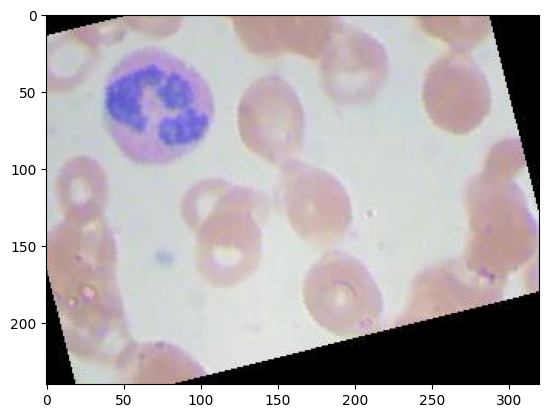

In [11]:
# check an image
plt.imshow(image.load_img(np.random.choice(train_images)))
plt.show()

# Build Model

In [12]:
def conv_block(input_, kernel_size, filters, strides=(2, 2)):
  f1, f2, f3 = filters

  x = Conv2D(f1, (1, 1), strides=strides, kernel_initializer='he_normal')(input_)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = Conv2D(f2, kernel_size, padding='same', kernel_initializer='he_normal')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = Conv2D(f3, (1, 1), kernel_initializer='he_normal')(x)
  x = BatchNormalization()(x)

  shortcut = Conv2D(f3, (1, 1), strides=strides, kernel_initializer='he_normal')(input_)
  shortcut = BatchNormalization()(shortcut)

  x = add([x, shortcut])
  x = Activation('relu')(x)

  return x


In [13]:
def identity_block(input_, kernel_size, filters):
  f1, f2, f3 = filters

  x = Conv2D(f1, (1, 1), kernel_initializer='he_normal')(input_)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = Conv2D(f2, kernel_size, padding='same', kernel_initializer='he_normal')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = Conv2D(f3, (1, 1), kernel_initializer='he_normal')(x)
  x = BatchNormalization()(x)

  x = add([x, input_])
  x = Activation('relu')(x)

  return x


In the code above, `f1` and `(1, 1)` represent different aspects of the convolutional layer defined by Conv2D:

- **f1**: this represents the number of filters in the convolutional layer. Each filter is essentially a small matrix that is convolved with the input data. The number of filters, `f1`, determines the depth of the output feature map. So, if `f1` is `64`, for instance, your convolutional layer will have `64` distinct filters, each learning to recognize different features from the input, resulting in an output feature map with a depth of `64`.

- **(1, 1)**: this represents the size of the kernel used in each filter. A kernel size of `(1, 1)` means that each filter has a 1x1 window. It scans through the input data one pixel at a time. In convolutional neural networks, different kernel sizes can be used to capture various spatial features. A 1x1 convolution, as used here, is typically for altering the depth of the feature map (such as increasing or reducing the number of channels) without affecting its spatial dimensions (height and width).

- **strides**: This parameter defines the step size that each filter takes as it moves across the input data. If strides is set to (2, 2), for example, the filter skips one pixel both horizontally and vertically between applications. This results in downsampling the spatial dimensions of the output feature map by a factor of 2 in both height and width.

**In summary**:

- `f1` is the number of distinct 1x1 filters applied to the input.
- `(1, 1)` is the size of each of these filters.
- `strides` determine how these filters stride across the input data, affecting the size of the output feature map.

In [14]:
# custom resnet
i = Input(shape=IMAGE_SIZE + [3])
x = ZeroPadding2D(padding=(3, 3))(i)
x = Conv2D(64, (7, 7), strides=(2, 2), padding='valid', kernel_initializer='he_normal')(x)

x = BatchNormalization()(x)
x = Activation('relu')(x)
x = ZeroPadding2D(padding=(1, 1))(x)
x = MaxPooling2D((3, 3), strides=(2, 2))(x)

x = conv_block(x, 3, [64, 64, 256], strides=(1, 1))
x = identity_block(x, 3, [64, 64, 256])
x = identity_block(x, 3, [64, 64, 256])

x = conv_block(x, 3, [128, 128, 512])
x = identity_block(x, 3, [128, 128, 512])
x = identity_block(x, 3, [128, 128, 512])
x = identity_block(x, 3, [128, 128, 512])

In [15]:
# bespoke layers
x = Flatten()(x)
x = Dense(1000, activation='relu')(x)
prediction = Dense(len(folders), activation='softmax')(x)

In [16]:
# create the model object
model = Model(inputs=i, outputs=prediction)

In [17]:
# view the structure of the model
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 230, 230, 3)          0         ['input_1[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv2d (Conv2D)             (None, 112, 112, 64)         9472      ['zero_padding2d[0][0]']      
                                                                                                  
 batch_normalization (Batch  (None, 112, 112, 64)         256       ['conv2d[0][0]']          

In [18]:
# iform methods
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=Adam(learning_rate=0.0001),
    metrics=['accuracy']
    )

In [19]:
# create an instance of ImageDataGenerator
train_gen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=lambda x: (x / 127.5) - 1
)

val_gen = ImageDataGenerator(
    preprocessing_function=lambda x: (x / 127.5) - 1
)

- `x /= 127.5`: This line scales the pixel values of the image. Normally, image pixel values range from 0 to 255 (for 8-bit images). Dividing by 127.5 transforms these values to a range of 0 to 2. This is a common preprocessing step in image processing, especially for neural network models, as it normalizes the data.

- `x -= 1.`: After the division, this line shifts the range from 0-2 to -1 to 1. This means the pixel values of the image will now range from -1 to 1. Centering the data around zero can help improve the performance of the model by ensuring that the input feature distribution is centered and symmetric.

In [20]:
# get label mapping for confusion matrix plot later
test_gen = val_gen.flow_from_directory(valid_path, target_size=IMAGE_SIZE, class_mode='sparse')
print(test_gen.class_indices)

labels = [None] * len(test_gen.class_indices)
for k, v in test_gen.class_indices.items():
  labels[v] = k

Found 2487 images belonging to 4 classes.
{'EOSINOPHIL': 0, 'LYMPHOCYTE': 1, 'MONOCYTE': 2, 'NEUTROPHIL': 3}


min:  -1.0 max:  1.0


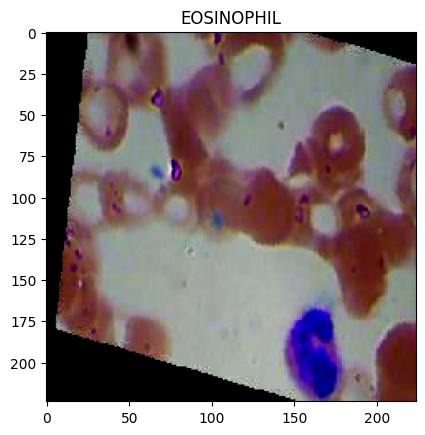

In [21]:
# should be NOT a strangely coloured image
for x, y in test_gen:
  print('min: ', x[0].min(), 'max: ', x[0].max())
  plt.title(labels[np.argmax(y[0])])
  plt.imshow(x[0])
  plt.show()
  break

In [22]:
# create generators
train_generator = train_gen.flow_from_directory(
  train_path,
  target_size=IMAGE_SIZE,
  shuffle=True,
  batch_size=batch_size,
  class_mode='sparse',
)
valid_generator = val_gen.flow_from_directory(
  valid_path,
  target_size=IMAGE_SIZE,
  shuffle=True,
  batch_size=batch_size,
  class_mode='sparse',
)


Found 9957 images belonging to 4 classes.
Found 2487 images belonging to 4 classes.


# Train Model

In [ ]:
checkpoint_filepath = '/tmp/checkpoint'

# calculate steps
steps_per_epoch = len(train_images) // batch_size
validation_steps = len(valid_images) // batch_size

# define callbacks
callbacks = [
    EarlyStopping(
        monitor='loss',
        patience=3,
        restore_best_weights=True
    ),
    ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True
    ),
]

# fit the model
r = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=callbacks
)


Epoch 1/16


# Evaluate Model

In [ ]:
def plot_history(history):
    metrics = list(history.keys())
    num_metrics = len(metrics) // 2
    plt.figure(figsize=(6 * num_metrics, 5))

    for i, metric in enumerate(metrics[:num_metrics]):
        plt.subplot(1, num_metrics, i + 1)
        plt.plot(history[metric], label=f'Training {metric.capitalize()}')
        plt.plot(history[f'val_{metric}'], label=f'Validation {metric.capitalize()}')
        plt.title(f'Training and Validation {metric.capitalize()}')
        plt.xlabel('Epoch')
        plt.ylabel(metric.capitalize())
        plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(r.history)